# Moment Comparison Between Microscopy & Flow Cytometry

In [1]:
import numpy as np
import pandas as pd
import glob
import mwc_induction_utils as mwc
import scipy.stats
import pymc3 as pm 
import theano.tensor as tt
import corner
from tqdm import tqdm
import scipy.optimize
import bokeh.models

import seaborn as sns
import matplotlib.pyplot as plt
import bokeh.io
import bokeh.plotting
import bokeh.layouts
np.random.seed(42)
bokeh.io.output_notebook()

Loading BokehJS ...


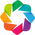

In [2]:
import holoviews as hv
hv.extension('bokeh')

In [3]:
pboc_opts = dict(bg_color='#FFEDCE') 
x = np.linspace(0, 2 * np.pi, 100)
y = 2 * np.sin(2 * np.sin(2 * np.sin(2 * x)))
data = (x,y)
hv.Curve(data, style=pboc_opts)

:Curve   [x]   (y)

##  Comparison of distributions

In [4]:
# Load the microscopy data set.
mic_files = glob.glob('../data/microscopy/*O2*microscopy*.csv')
mic_df = pd.concat([pd.read_csv(f, comment='#') for f in mic_files])

# Only keep RBS1027 for the purposes of this comparison.
mic_df = mic_df[mic_df['rbs']=='RBS1027']

# Load the flow data sets.
flow_files = glob.glob('../data/flow/*O2*IPTG.csv')
flow_df = []
alpha = 0.4
for i, file in enumerate(flow_files):
    # Load the data set and gate
    _df = pd.read_csv(file, comment='#')
    gated = mwc.auto_gauss_gate(_df, alpha=alpha)
    
    # Get the string of the concentration. 
    name_split = file.split('_')
    conc = float(name_split[-1].split('uM')[0])
    date = name_split[0].split('/')[-1]
    operator = name_split[2]
    rbs = name_split[3]
    _df = _df.loc[:, ['FITC-A', 'FSC-A', 'SSC-A']]
    _df.insert(0, 'rbs', rbs)
    _df.insert(0, 'operator', operator)
    _df.insert(0, 'IPTG_uM', conc)
    _df.insert(0, 'date', date)
    flow_df.append(_df)
    
flow_df = pd.concat(flow_df, axis=0)


In [5]:
def ecdf(data):
    return np.sort(data), np.arange(0, len(data)) / len(data)

In [55]:
import imp
imp.reload(mwc)

<module 'mwc_induction_utils' from '/Users/gchure/Lab/PhillipsLab201401-XXX/lab_code/physical_flow_cytometry/code/mwc_induction_utils.py'>

In [57]:
plot_kwargs = {'plot_width':500, 'plot_height':300}
p1 = mwc.bokeh_boiler()
p2 = mwc.bokeh_boiler()
grouped = mic_df.groupby('IPTG_uM')
colors = sns.color_palette('Blues_r', n_colors=20)
colors = colors.as_hex()
i = 0 
for g, d_mic in grouped: 
    x, y = ecdf(d_mic['mean_intensity'])
    p1.line(np.log10(x), y, line_width=2.5, color=colors[i],
            alpha=0.75, legend=str(g)) 
    i += 1  
    
grouped = flow_df.groupby('IPTG_uM')
i = 0
for g, d_flow in grouped:
    x, y = ecdf(d_flow['FITC-A'])
    p2.line(np.log10(x), y, line_width=2.5, color=colors[i], legend=str(g))
    i += 1
p1.xaxis.axis_label = 'log mean pixel intensity (a.u.)'
p1.yaxis.axis_label = 'ECDF'
p1.legend.location = 'bottom_right'
# p1.legend.title = '[IPTG] (µM)'
p1.title.text = ' distributions from microscopy '
p1.legend.orientation='horizontal'

p2.xaxis.axis_label='log mean object intensity'
p2.title.text = 'distributions from flow cytometry'
bokeh.io.show(p1)
                       

In [58]:
p1.legend

In [50]:
p1.axis.

SyntaxError: invalid syntax (<ipython-input-50-4a46febcb338>, line 1)

In [51]:
p = bokeh.plotting.figure()
p.xaxis.axis_label_text_font_style = 'italic'

To compare the distributions between the two methods, we can look at the **[central moments]()**, which provides information on the shape of the distribution rather than just the location. We can mathematically describe the $k-$th central moment of a data set as 

$$
m_k = {1 \over n}\sum\limits_i^n(x_i - \bar{x})^k,
$$

where $m_k$ is the $k-$th moment, $x_i$ is the $i$-th data point in the data set, and $\bar{x}$ is the mean.


In [ ]:
p = mwc.bokeh_boiler(**dict(y_axis_type='log'))

moments = [2, 3, 4, 5, 6, 7]

flow_dup_files = glob.glob('../data/5000uM_IPTG_distributions/*IPTG.csv')
for f in flow_dup_files:
    d_flow = pd.read_csv(f, comment='#')
    gated = mwc.auto_gauss_gate(d_flow, alpha=0.4)
    for m in moments:
#     _mic_moment = scipy.stats.moment(d_mic['mean_intensity'], moment=m) 
        _flow_moment = scipy.stats.moment(gated['FITC-A'], moment=m) 
#     p.circle(m, _mic_moment, size=10, legend='microscopy', color='dodgerblue')
        p.circle(m, _flow_moment, size=5, legend='flow cytometry', color='tomato',
                alpha=0.5)
    
mic_dup_files = glob.glob('../data/5000uM_IPTG_distributions/*microscopy*.csv')
for f in mic_dup_files:
    d_mic = pd.read_csv(f, comment='#')
    d_mic = d_mic[d_mic['IPTG_uM']==5000]
    for m in moments:
        _mic_moment = scipy.stats.moment(d_mic['mean_intensity'], moment=m)
        p.circle(m, _mic_moment, size=5, legend='microscopy', color='dodgerblue',
                alpha=0.5)
    
p.xaxis.axis_label = 'central moment order'
p.yaxis.axis_label = 'central moment value'
p.legend.location = 'top_left'
p.legend.background_fill_color = '#E3DCD0'
p.legend.border_line_color = '#FFFFFF'
bokeh.io.show(p)
    

## Parameter estimation using population means 

In [ ]:
p.circle?

In [27]:
# Compare the hpd of the values. 
R = 260  # Number of repressor molecules
ep_r = -13.9 #Binding energy of repressor to the DNA
ep_ai = 4.5  # Energetic difference between allosteric states
fixed_params = [R, ep_r, ep_ai]

# Set up the model and define the priors. 
def jeffreys(val):
    return -tt.log(val)

def traceframe(trace, model):
    df = pm.trace_to_dataframe(trace)
    lnprob = []
    for t in tqdm(trace):
        lnprob.append(model.logp(t))
    df.insert(np.shape(df)[1], 'lnprob', lnprob)        
    return df



In [28]:
flow_model = pm.Model()
mic_model = pm.Model()
models = [flow_model, mic_model]
methods = ['flow cytometry', 'microscopy']
model_df = [O2_flow, O2_mic]
N_ns = 4.6E6

ep_r = -13.9
dfs = []
for i, m in enumerate(models):
    IPTG = model_df[i]['IPTG_uM'].values
    if i == 0:
        fc_obs = model_df[i]['fold_change_A'].values
    else:
        fc_obs = model_df[i]['fold_change'].values
    
    with m:
        ep_a = pm.Uniform('ep_a', lower=-10, upper=10, testval=5)
        ep_i = pm.Uniform('ep_i', lower=-10, upper=10, testval=-0.5)
        sigma = pm.HalfNormal('sigma', sd=1)
#         sigma = pm.DensityDist('sigma', jeffreys, testval=1)

        p_act = (1 + IPTG * np.exp(-ep_a))**2 / ((1 + IPTG * np.exp(-ep_a))**2 +\
            np.exp(-ep_ai) * (1 + IPTG * np.exp(-ep_i))**2)
        fc_theo = (1 + p_act * (2 * model_df[i]['repressors'] / N_ns) * np.exp(-model_df[i]['binding_energy']))**-1
        like = pm.Normal('likelihood',mu=fc_theo, sd=np.sqrt(sigma), observed=fc_obs)
        
        # Find the map. 
        _MAP = pm.find_MAP(model=m, fmin=scipy.optimize.fmin_powell)
        trace = pm.sample(start=_MAP, draws=10000, tune=10000)
        
    df = traceframe(trace, model=m)
#     df.insert(0, 'method', methods[i])
    dfs.append(df)
 

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: -380.438966
         Iterations: 3
         Function evaluations: 124


Average ELBO = 369.29: 100%|██████████| 200000/200000 [00:17<00:00, 11198.96it/s]
Finished [100%]: Average ELBO = 369.29
INFO:pymc3:Finished [100%]: Average ELBO = 369.29
100%|██████████| 10000/10000 [00:00<00:00, 10851.14it/s]
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: -68.357939
         Iterations: 4
         Function evaluations: 171


Average ELBO = 60.011: 100%|██████████| 200000/200000 [00:16<00:00, 12207.44it/s]
Finished [100%]: Average ELBO = 60.023
INFO:pymc3:Finished [100%]: Average ELBO = 60.023
100%|██████████| 10000/10000 [00:00<00:00, 11414.14it/s]


In [367]:
def fold_change(num_rep, c_range, ep_r, ep_a, ep_i, 
                ep_ai=4.5, n_ns=4.6E6, n_sites=2):
    """
    Computes the fold-change in gene expression for a simple
    repression system. 
    
    Parameters
    ----------
    num_rep : int or float
        Number of repressors per cell.
    c_range : 1d-array or float
        Range of IPTG concentrations over which to evaluate
        the fold-change. This should be in units of µM.
    ep_r : float
        Binding energy of the repressor to the DNA. This is 
        in units of k_BT.
    ep_a : float
        Binding energy of inducer to the active repressor.
        This is in units of k_BT
    ep_i : float
        Binding energy of inducer to the inactive repressor.
        This is in units of k_BT.
    ep_ai : float, default 4.5
        Energetic difference between the active and inactive
        state of the repressor. This is in units of k_BT.
    n_ns : float default 4.6x10^6
        Number of nonspecific binding sites available to the
        repressor. Default value is the length of the E. coli
        genome.  
    n_sites : int
        Number of allosteric sites on the repressor. 
        
    Returns
    -------
    fc : 1d-array
        Fold-change in gene expression evaluated at every 
        concentration provided in c_range.  
    """
    
    # Compute the probability of a repressor being active. 
    numer = (1 + c_range * np.exp(-ep_a))**n_sites
    denom = numer + np.exp(-ep_ai) *\
        (1 + c_range * np.exp(-ep_i))**n_sites    
    p_act = numer / denom
    
    # Compute and return the fold change. 
    repression = 1 + p_act * (R / n_ns) * np.exp(-ep_r) 
    return repression**-1

def jeffreys(val):
    return -tt.log(val)

def mcmc_sample_kaki(params, priors, observed, draws=5000,
                     tune=10000, n_jobs=0):
    num_rep, c_range, ep_r = params
    with pm.Model() as model:
        # Set the priors
        ep_a = pm.Uniform('ep_a', lower=priors['ep_a']['lower'],
                                  upper=priors['ep_a']['upper'],
                                  testval=priors['ep_a']['testval'] )
        ep_i = pm.Uniform('ep_i', lower=priors['ep_i']['lower'],
                                  upper=priors['ep_i']['upper'],
                                  testval=priors['ep_i']['testval'])
        sigma = pm.DensityDist('sigma', jeffreys, testval=1)
        
        # Compute the expected value. 
        theo = fold_change(num_rep, c_range, ep_r, ep_a, ep_i)
        
        # Compute the likelihood.
        like = pm.Normal('likelihood', mu=theo, sd=sigma**2, observed=observed)
        
        # Find the MAP to initialize the walkers.
        map_val = pm.find_MAP(model=model, fmin=scipy.optimize.fmin_powell)
        
        # Sample the posterior. 
        trace = pm.sample(draws=draws, tune=tune, njobs=n_jobs)
     
    return trace, model
        
def trace_to_df(trace, model):
    """
    Converts the trace from a pymc3 sampling trace to a
    Pandas DataFrame.
    """
    
    def compute_logp(chain):
        """
        Computes the log probability of the provided trace 
        at a given chain.
        """
        names = trace.varnames
        var_dict = {}
        for n in names:
            var_dict[n] = trace.get_values(n, chains=chain)
        sample_df = pd.DataFrame(var_dict)
        
        logp =  [model.logp(sample_df.iloc[step]\
                           ) for step in range(len(sample_df))]
        return logp 
    
    chains = trace.chains 
    for c in tqdm(chains, desc='Processing chains'):
        logp = compute_logp(c)
        if c == 0:
            df = pm.trace_to_dataframe(trace, chains=c)
            df.insert(np.shape(df)[1], 'logp', logp)
        else:
            _df = pm.trace_to_dataframe(trace, chains=c)
            _df.insert(np.shape(_df)[1], 'logp', logp)
            df.append(_df, ignore_index=True)
            
    return df    


# #################
def hpd(trace, mass_frac):
    """
    Returns highest probability density region given by
    a set of samples.
    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For hreple, `massfrac` = 0.95 gives a
        95% HPD.

    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD

    Notes
    -----
    We thank Justin Bois (BBE, Caltech) for developing this function.
    http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)

    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)

    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n - n_samples]

    # Pick out minimal interval
    min_int = np.argmin(int_width)

    # Return interval
    return np.array([d[min_int], d[min_int + n_samples]])
    
     
def compute_statistics(df, ignore_vars='logp'):
    """
    Computes the mode and highest probability density (hpd)
    of the 
    """
    
    # Set up the multi indexing. 
    var_names = np.array(df.keys())
    if ignore_vars is not None:
        var_names = var_names[var_names != ignore_vars]  
    
    # Generate arrays for indexing and zip as tuples.
    names = [var for var in var_names] * 3 
    stats = ['mode', 'hpd_min', 'hpd_max']
    stats = np.array([[s] * len(var_names) for s in stats]).flatten()
    tuples = list(zip(*[names, stats]))
    
    # Define the index.
    index = pd.MultiIndex.from_tuples(tuples, names=['var', 'stat'])    
    
    # Determine the mode for each 
    mode_ind = np.argmax(df['logp'])
    stat_vals = [df.iloc[mode_ind][var] for var in var_names]  
    # Compute the min and max vals of the HPD.
    hpd_min, hpd_max = [], []
    for i, var in enumerate(var_names):
        _min, _max = hpd(df[var], 0.95)
        hpd_min.append(stat_vals[i] - _min)
        hpd_max.append(_max - stat_vals[i])
    for _ in hpd_min:
        stat_vals.append(_)
    for _ in hpd_max:
        stat_vals.append(_)
       
    # Add them to the array for the multiindex
    flat_vals = np.array([stat_vals]).flatten()
    var_stats = pd.Series(flat_vals, index=index)
    
    return var_stats

In [370]:
# Read in the data frame.
flow_master = pd.read_csv('../data/flow_master.csv', comment='#')
flow_master = flow_master[(flow_master['operator']=='O2') & 
                         (flow_master['rbs']=='RBS1027')]
params = [2 * flow_master['repressors'].values,
          flow_master['IPTG_uM'].values,
         flow_master['binding_energy'].values]
priors = dict(ep_a=dict(lower=-10, upper=10, testval=4.5),
              ep_i=dict(lower=-10, upper=10, testval=-0.5))
observed = flow_master['fold_change_A'].values

# Sample the distribution. 
flow_trace = mcmc_sample_kaki(params, priors, observed, n_jobs=None)
flow_df = trace_to_df(*(flow_trace)) 
flow_df.loc[:, 'ep_i'] = np.exp(flow_df['ep_i'])
flow_df.loc[:, 'ep_a'] = np.exp(flow_df['ep_a'])
flow_stats = compute_statistics(flow_df)
flow_stats['ep_i']

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: -189.988601
         Iterations: 5
         Function evaluations: 234


Average ELBO = 177.54: 100%|██████████| 200000/200000 [00:17<00:00, 11277.03it/s]
Finished [100%]: Average ELBO = 177.51
INFO:pymc3:Finished [100%]: Average ELBO = 177.51
Processing chains: 100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


stat
mode       0.539542
hpd_min    0.042835
hpd_max    0.040762
dtype: float64

In [372]:
flow_stats['ep_a']


stat
mode       140.280788
hpd_min     23.669884
hpd_max     26.593804
dtype: float64

In [76]:
flow_trace.nchains

6

In [77]:
len(flow_trace)

5000

In [79]:
df = pm.trace_to_dataframe(flow_trace)
len(df)

30000

In [85]:
flow_trace

<MultiTrace: 6 chains, 5000 iterations, 5 variables>

In [91]:
num_rep, c_range, ep_r = params
draws = 5000
tune = 10000
n_jobs = None
with pm.Model() as model:
    # Set the priors
    ep_a = pm.Uniform('ep_a', lower=priors['ep_a']['lower'],
                              upper=priors['ep_a']['upper'],
                              testval=priors['ep_a']['testval'] )
    ep_i = pm.Uniform('ep_i', lower=priors['ep_i']['lower'],
                              upper=priors['ep_i']['upper'],
                              testval=priors['ep_i']['testval'])
    sigma = pm.DensityDist('sigma', jeffreys, testval=1)
    
    # Compute the expected value. 
    theo = fold_change(num_rep, c_range, ep_r, ep_a, ep_i)
    
    # Compute the likelihood.
    like = pm.Normal('likelihood', mu=theo, sd=sigma**2, observed=observed)
    
    # Find the MAP to initialize the walkers.
    map_val = pm.find_MAP(model=model, fmin=scipy.optimize.fmin_powell)

    # Sample the posterior. 
    trace = pm.sample(draws=draws, tune=tune, njobs=n_jobs)


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...


Optimization terminated successfully.
         Current function value: 1095.538246
         Iterations: 4
         Function evaluations: 182


Average ELBO = -1,108.5: 100%|██████████| 200000/200000 [00:32<00:00, 6210.37it/s]  
Finished [100%]: Average ELBO = -1,108.5
INFO:pymc3:Finished [100%]: Average ELBO = -1,108.5
100%|██████████| 5000/5000 [00:54<00:00, 91.00it/s] 


In [60]:
dict(plot=dict(lower=1, upper=2))

{'plot': {'lower': 1, 'upper': 2}}

In [98]:
logp =[]
for t in trace:
    logp.append(model.logp(t))


In [129]:
# set chain0.
df = pm.trace_to_dataframe(trace, chains=0)


5000

In [130]:
trace.chains

[0, 1, 2, 3, 4, 5]

In [143]:
trace.model


AttributeError: 'MultiTrace' object has no attribute 'model'

In [194]:
def trace_to_df(trace, model):
    """
    Converts the trace from a pymc3 sampling trace to a
    Pandas DataFrame.
    """
    
    def compute_logp(chain):
        """
        Computes the log probability of the provided trace 
        at a given chain.
        """
        names = trace.varnames
        var_dict = {}
        for n in names:
            var_dict[n] = trace.get_values(n, chains=chain)
        sample_df = pd.DataFrame(var_dict)
        
        logp =  [model.logp(sample_df.iloc[step]\
                           ) for step in range(len(sample_df))]
        return logp 
    
    chains = trace.chains 
    for c in tqdm(chains, desc='Processing chains'):
        logp = compute_logp(c)
        if c == 0:
            df = pm.trace_to_dataframe(trace, chains=c)
            df.insert(np.shape(df)[1], 'logp', logp)
        else:
            _df = pm.trace_to_dataframe(trace, chains=c)
            _df.insert(np.shape(_df)[1], 'logp', logp)
            df.append(_df, ignore_index=True)
            
    return df 

In [195]:
z = trace_to_df(trace, model)
z.head()


Processing chains...: 100%|██████████| 6/6 [00:08<00:00,  1.33s/it]


,sigma,ep_a,ep_i,logp
0,0.596711,4.130198,-1.121824,-1095.6094890849547
1,0.596711,4.130198,-1.121824,-1095.6094890849547
2,0.603238,4.108365,-1.128286,-1097.5269530759438
3,0.590450,4.223317,-1.079097,-1096.9514802557194
4,0.600812,4.107800,-1.159360,-1096.9011786723174


In [186]:
mode = z.iloc[np.argmax(z['logp'])]

63.7147143325


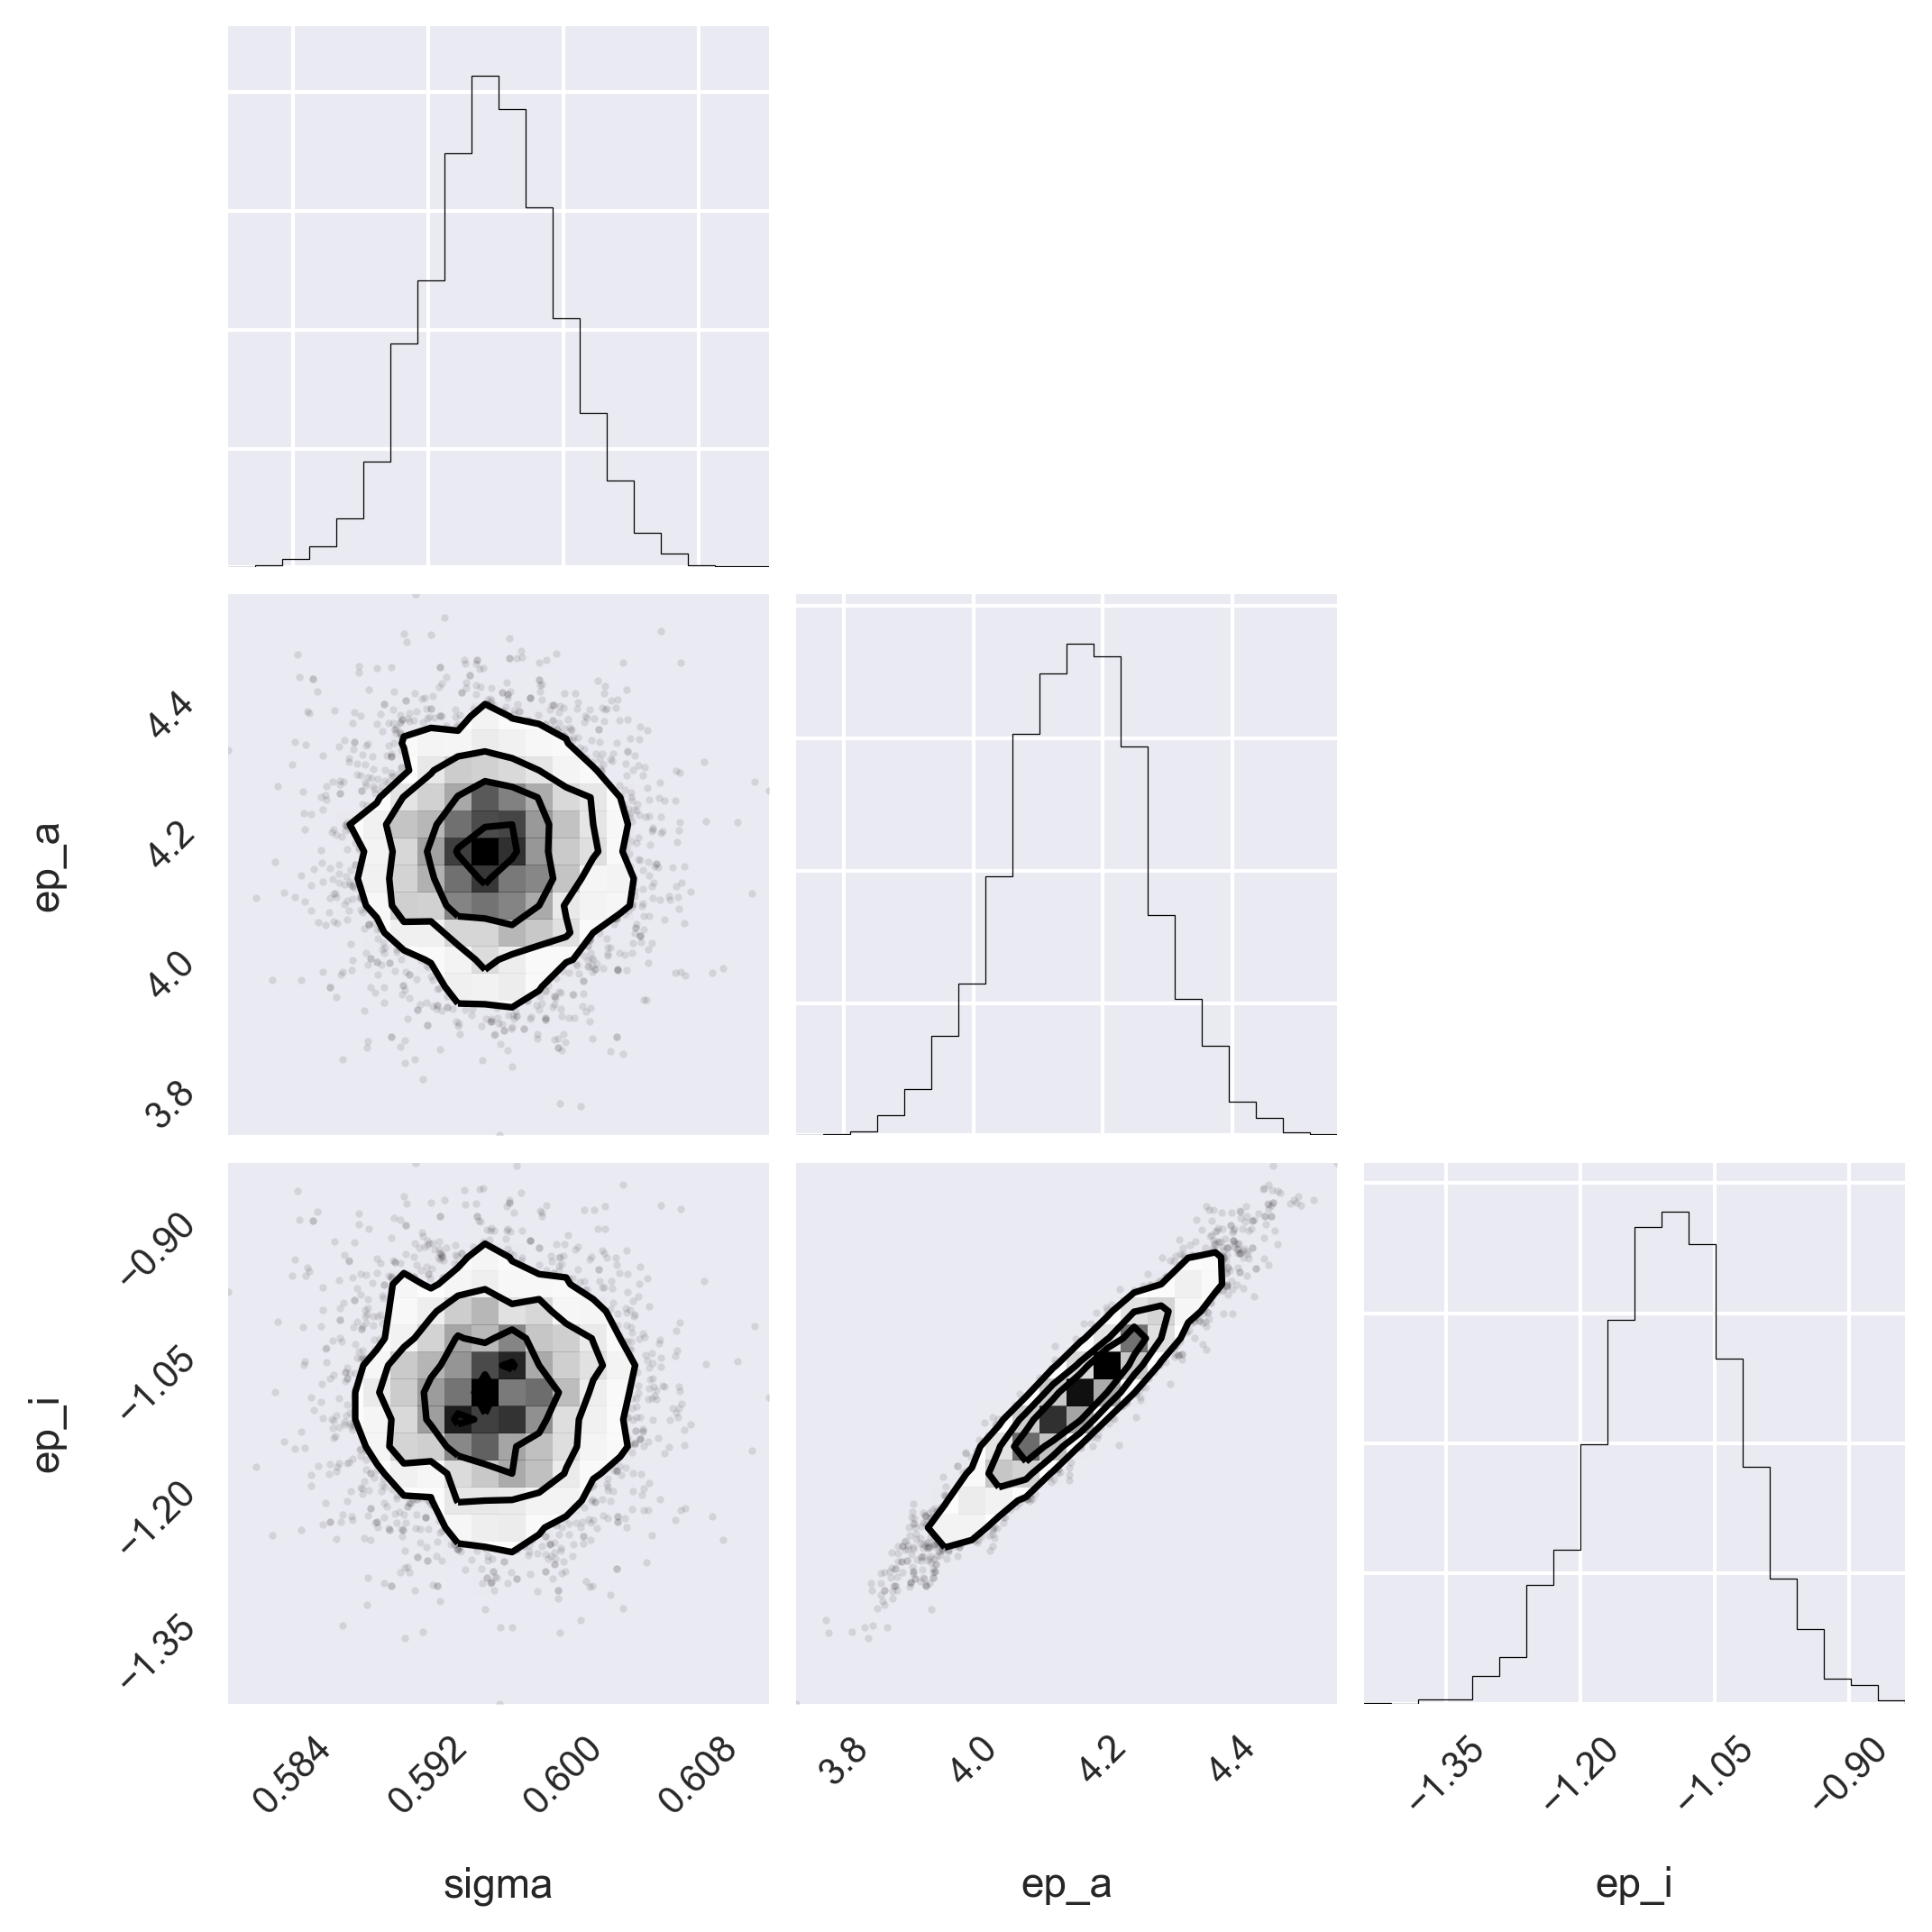

In [189]:
% matplotlib inline
_ = corner.corner(z.drop('logp', axis=1))

In [196]:
mode = z.iloc[np.argmax(z['logp'])]

In [199]:
flow_master['operator'].unique()

array(['O2', 'O1', 'O3'], dtype=object)

In [29]:
p = mwc.bokeh_boiler()

colors = ['dodgerblue', 'tomato']
for i, d in enumerate(dfs):
    x, y = ecdf(d['ep_a'])
    p.line(x,y, color=colors[i], line_width=2)

bokeh.io.show(p)

In [39]:
# Randomly choose three days. 
flow_master = pd.read_csv('../data/flow_master.csv', comment='#')
O2_flow = flow_master[((flow_master['operator']=='O2') |
                      (flow_master['operator']=='O1')) &
                      (flow_master['rbs']=='RBS1027')]

p = mwc.bokeh_boiler(**{'x_axis_type':'log', 
                        'x_axis_label':'[IPTG] (µM)',
                        'y_axis_label':'fold-change',
                       'y_range':[-0.01, 1.0]})

grouped = O2_flow.groupby(['operator'])

for g, d in grouped:
    IPTG = d['IPTG_uM'] / 1E6
    if g == 'O1':
        color = 'tomato'
    else:
        color = 'dodgerblue'
    p.circle(IPTG, d['fold_change_A'], color=color, alpha=0.3)
    
# Microscopy. 
mic_master = pd.read_csv('../data/microscopy_master.csv', comment='#')
O2_mic = mic_master[((mic_master['operator']=='O2') | (mic_master['operator'] == 'O1')) &\
                    (mic_master['rbs']=='RBS1027')]
grouped = O2_mic.groupby(['operator'])

for g, d in grouped:
    IPTG = d['IPTG_uM'] / 1E6
    if g == 'O1':  
        color = 'tomato'
    else:
        color = 'dodgerblue'
        
    p.circle(IPTG, d['fold_change'], fill_color='white',
            line_width=1.5, size=8, alpha=0.5, line_color=color)
        
    


# Add the necessary legend. 
p.circle([],[], fill_color='white', line_color='black', legend='microscopy')
p.circle([], [], color='black', legend='flow cytometry')
p.line([], [], color='dodgerblue', legend = 'operator O2', line_width=3)
p.line([], [], color='tomato', legend='operator O1', line_width=3)
p.legend.background_fill_color = '#E3DCD0'
p.legend.border_line_color = '#FFFFFF'
p.legend.location = 'top_left'

p1 = mwc.bokeh_boiler()
p2 = mwc.bokeh_boiler()
p3 = mwc.bokeh_boiler()
0
8
colors = ['slategray', 'skyblue']
methods = ['flow cytometry', 'microscopy']
# for i, d in enumerate(dfs):
#     # Compute the ecdf. 
#     ka_x, ka_y = ecdf(np.exp(d['ep_a']))
#     ki_x, ki_y = ecdf(np.exp(d['ep_i']))
#     p2.line(ka_x, ka_y, line_width=2, color=colors[i]) 
#     p3.line(ki_x, ki_y, line_width=2, color=colors[i])
 


# p1.quad(top=mic_y/np.sum(mic_y), bottom=0, left=mic_x[:-1], right=mic_x[1:], color='skyblue',
#       alpha=0.8)
# p1.quad(top=flow_y/np.sum(flow_y), bottom=0, left=flow_x[:-1], right=flow_x[1:], color='slategray',
#       alpha=0.5)



# Now generate the 
bokeh.io.show(ell)


In [ ]:
bin_min = np.min([np.min(dfs[0].ep_i), np.min(dfs[1].ep_i)])
bin_max = np.max([np.max(dfs[0].ep_i), np.max(dfs[1].ep_i)])
bins = np.linspace(np.exp(bin_min), np.exp(bin_max), 65)
flow_y, flow_x = np.histogram(np.exp(dfs[0].ep_i), bins=bins)
mic_y, mic_x = np.histogram(np.exp(dfs[1].ep_i), bins=bins)

p1 = mwc.bokeh_boiler()
p2 = mwc.bokeh_boiler()
p3 = mwc.bokeh_boiler()
0
8
colors = ['slategray', 'skyblue']
methods = ['flow cytometry', 'microscopy']
for i, d in enumerate(dfs):
    # Compute the ecdf. 
    ka_x, ka_y = ecdf(np.exp(d['ep_a']))
    ki_x, ki_y = ecdf(np.exp(d['ep_i']))
    p2.line(ka_x, ka_y, line_width=2, color=colors[i]) 
    p3.line(ki_x, ki_y, line_width=2, color=colors[i])
 


p1.quad(top=mic_y/np.sum(mic_y), bottom=0, left=mic_x[:-1], right=mic_x[1:], color='skyblue',
      alpha=0.8)
p1.quad(top=flow_y/np.sum(flow_y), bottom=0, left=flow_x[:-1], right=flow_x[1:], color='slategray',
      alpha=0.5)

ell = bokeh.layouts.layout([[p1, p2], [p3]], sizing_mode='stretch_both')
# bokeh.io.show(ell)
# bokeh.io.export_png(ell, filename='test.png')
# bokeh.io.show(p2)



In [ ]:
bin_min = np.min([np.min(dfs[0].ep_i), np.min(dfs[1].ep_i)])
bin_max = np.max([np.max(dfs[0].ep_i), np.max(dfs[1].ep_i)])
bins = np.linspace(np.exp(bin_min), np.exp(bin_max), 65)
flow_y, flow_x = np.histogram(np.exp(dfs[0].ep_i), bins=bins)
mic_y, mic_x = np.histogram(np.exp(dfs[1].ep_i), bins=bins)

p1 = mwc.bokeh_boiler()
p2 = mwc.bokeh_boiler()
p3 = mwc.bokeh_boiler()


colors = ['slategray', 'skyblue']
methods = ['flow cytometry', 'microscopy']
for i, d in enumerate(dfs):
    # Compute the ecdf. 
    ka_x, ka_y = ecdf(np.exp(d['ep_a']))
    ki_x, ki_y = ecdf(np.exp(d['ep_i']))
    p2.line(ka_x, ka_y, line_width=2, color=colors[i]) 
    p3.line(ki_x, ki_y, line_width=2, color=colors[i])
 


p1.quad(top=mic_y/np.sum(mic_y), bottom=0, left=mic_x[:-1], right=mic_x[1:], color='skyblue',
      alpha=0.8)
p1.quad(top=flow_y/np.sum(flow_y), bottom=0, left=flow_x[:-1], right=flow_x[1:], color='slategray',
      alpha=0.5)

ell = bokeh.layouts.layout([[p1, p2], [p3]], sizing_mode='stretch_both')
# bokeh.io.show(ell)
# bokeh.io.export_png(ell, filename='test.png')
bokeh.io.show(p2)

